<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Neural_Networks_as_Feature_Extractors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks as Feature Extractors

In general, there are two types of transfer learning when applied to deep learning for computer vision:

- Treating networks as arbitrary feature extractors.
- Removing the fully-connected layers of an existing network, placing new FC layer set on top of the CNN, and fine-tuning these weights (and optionally previous layers) to recognize object classes.

In this notebook, we will focus on the first type. We will be using a pretrained convolutional neural network to extract the internal features from our image dataset and we will then pass those features to a traditional machine learning model for performing the classification task. Extracting features here essentially means to quantify the internal representations of the images. 

The key idea here is to not use the dense layers of a pretrained convolutional neural network which are responsible for the classification task. So, let's go ahead and load in a pretrained CNN using the high level Keras API of TensorFlow. 

**Note** that to be able to follow along with this notebook, I assume you are familiar with the basics of image classification using deep learning. 

In [0]:
# Imports
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
import numpy as np

As usual, we are starting off by importing the packages we would need for running our experiments. We are going to use VGG16 for the feature extraction purpose. 

In [2]:
import tensorflow as tf
 
print(tf.__version__)

2.0.0-alpha0


In [0]:
# Load the VGG16 model but exclude the classification layers
extractor_model = VGG16(weights='imagenet', include_top=False)

In this case, we are using a VGG16 network which has been trained on the mammoth ImageNet dataset. This network is going to act as the feature extractor. Let's now load in a dataset from the `tensorflow_datasets` module. We will be using the **Cats vs. Dogs** dataset. 

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
# Available datasets
tfds.list_builders()[:10]

['abstract_reasoning',
 'bair_robot_pushing_small',
 'caltech101',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_corrupted']

Let's load in the dataset now. 

In [0]:
# Specify the splits: 80:20
SPLIT_WEIGHTS = (8, 2)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_test), metadata = tfds.load(
                'cats_vs_dogs', split=list(splits),
                with_info=True, as_supervised=True)

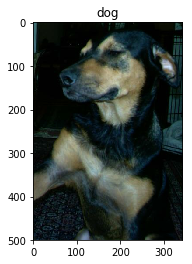

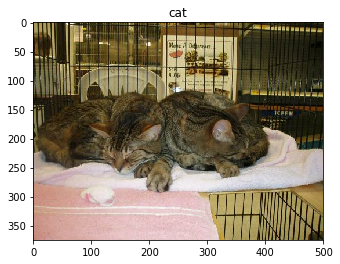

In [7]:
# Show two image from the train set
import matplotlib.pyplot as plt
%matplotlib inline

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

We will now give the images in the training and testing sets a bit of treatment - 
- We will give the images a uniform shape of 224*224
- We will standardize the pixel values

And that's it. 

In [0]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

The above function now can be applied as a `map` to the train and test sets. 

In [0]:
# Preprocess the images
train = raw_train.map(format_example)
test = raw_test.map(format_example)

Let's now prepare batches of 32 and shuffle the images in the training set so that there is no bias in the ordering. 

In [0]:
# Prepare batches of 32 and randomly shuffle the training images
train_batches = train.shuffle(1024).batch(32)
test_batches = test.batch(32)

We are now ready to employ the partial VGG16 network to extract features from the images. 

In [12]:
# Extract the features from training and testing sets

train_features = extractor_model.predict(train_batches)
test_features = extractor_model.predict(test_batches)

train_features.shape, test_features.shape

((18622, 7, 7, 512), (4640, 7, 7, 512))

Now that we have successfully extracted the features from the images, we will have to reshape them for using with an off-the-shelf traditional ML model. By reshaping, we will have flattened the feature vectors.  

In [13]:
# Reshape the features (flattening)
train_features = train_features.reshape((train_features.shape[0], 
                                         512 * 7 * 7))
test_features = test_features.reshape((test_features.shape[0], 
                                         512 * 7 * 7))

train_features.shape, test_features.shape

((18622, 25088), (4640, 25088))

Now that the feature vectors are flattened, we can extract the image labels from the batches we had prepared. 

In [0]:
# Extract the training labels
train_labels = [label for _, labels in train_batches for label in labels.numpy()]
train_labels = np.array(train_labels).reshape(-1, 1)

In [0]:
# Extract the test labels
test_labels = [label for _, labels in test_batches for label in labels.numpy()]
test_labels = np.array(test_labels).reshape(-1, 1)

The data is now ready to be used with another traditional ML model. Here, we will be using Logistic Regression. But first, let's import the last few packages. 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [32]:
# Fit the model
log_reg = LogisticRegression()
log_reg.fit(train_features, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We can now test the performance of the Logistic Regression model. 

In [36]:
# Derive performance metrics
y_preds = log_reg.predict(test_features)
print(classification_report(test_labels, y_preds,
                           target_names=['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.96      0.96      0.96      2337
         dog       0.96      0.96      0.96      2303

    accuracy                           0.96      4640
   macro avg       0.96      0.96      0.96      4640
weighted avg       0.96      0.96      0.96      4640



In [38]:
print('Accuracy on the testing set', accuracy_score(test_labels, y_preds)*100)

Accuracy on the testing set 96.20689655172414


The performance is quite compelling given the fact that the Logistic Regression model is built with default hyperparameter values. We could go for hyperparameter tuning to further psuh this performance. 

### Resources and references:
- [Transfer Learning Using Pretrained ConvNets](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning)
- [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview)
- [Deep Learning for Computer Vision by Adrian Rosebrock (Practitioner Bundle)](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/)